# Small Nimm 6 tournament

In [1]:
import numpy as np
import logging
import sys
import torch
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("../")

from rl_6_nimmt import Tournament, GameSession
from rl_6_nimmt.agents import Human, DrunkHamster, BatchedACERAgent, Noisy_D3QN_PRB_NStep, MCSAgent, PolicyMCSAgent, PUCTAgent

logging.basicConfig(format="%(message)s",level=logging.INFO)
for name in logging.root.manager.loggerDict:
    if not "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.WARNING)


## Agents

In [2]:
agents = {}
    
agents[f"Random"] = DrunkHamster()
agents[f"D3QN"] = Noisy_D3QN_PRB_NStep(history_length=int(1e5), n_steps=10)
agents[f"ACER"] = BatchedACERAgent(minibatch=10)
agents[f"MCS"] = MCSAgent(mc_max=200)
agents[f"Alpha0.5"] = PUCTAgent(mc_max=200)

for agent in agents.values():
    try:
        agent.train()
    except:
        pass

merle = Human("Merle")


In [3]:
tournament = Tournament(min_players=2, max_players=4)

for name, agent in agents.items():
    tournament.add_player(name, agent)

print(tournament)

Tournament after 0 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
               Random |     0 |          - |            - | 1600 
                 D3QN |     0 |          - |            - | 1600 
                 ACER |     0 |          - |            - | 1600 
                  MCS |     0 |          - |            - | 1600 
             Alpha0.5 |     0 |          - |            - | 1600 
-----------------------------------------------------------------


## Load existing state (skip when running this for the first time)

In [13]:
agents, tournament = pickle.load(open("./.tournament.pickle", "rb"))

print(tournament)

Tournament after 2000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
          MCS_0_0_0_0 |  1055 |      -7.13 |         0.46 | 1772 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
     Alpha0.5_0_1_1_0 |  1022 |      -6.76 |         0.48 | 1695 
     Alpha0.5_0_1_0_0 |  1033 |      -6.53 |         0.50 | 1739 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
-----------------------------------------------------------------


## Let the games begin! Stage 1: 5 x 400 games, 6 players, 200 MC steps

In [5]:
num_games = 2000
block_len = 400

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)
        
    if tournament.total_games < num_games:
        tournament.evolve(max_players=6, max_per_descendant=2, copies=(2,))


  0%|          | 0/400 [00:00<?, ?it/s]../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
  2%|▏         | 6/400 [01:57<2:04:58, 19.03s/it]../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
  4%|▍         | 15/400 [04:59<2:15:37, 21.14s/it]../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
100%|██████████| 400/400 [2:23:07<00:00, 21.47s/it]  
Copying player Alpha0.5 into 2 instances!


Tournament after 400 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
               Random |   227 |     -11.82 |         0.23 | 1423 
                 D3QN |   238 |     -11.92 |         0.22 | 1566 
                 ACER |   242 |     -13.74 |         0.17 | 1558 
                  MCS |   237 |      -6.87 |         0.50 | 1659 
             Alpha0.5 |   243 |      -6.16 |         0.56 | 1794 
-----------------------------------------------------------------


100%|██████████| 400/400 [3:21:44<00:00, 30.26s/it]  
Copying player Alpha0.5_0 into 2 instances!
Removing player Alpha0.5_1


Tournament after 800 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
           Alpha0.5_0 |   442 |      -6.19 |         0.54 | 1829 
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
                MCS_0 |   445 |      -6.98 |         0.47 | 1729 
               D3QN_0 |   422 |     -12.50 |         0.19 | 1450 
               ACER_0 |   437 |     -13.40 |         0.18 | 1546 
             Random_0 |   433 |     -12.87 |         0.21 | 1428 
-----------------------------------------------------------------


100%|██████████| 400/400 [3:51:54<00:00, 34.79s/it]    
Copying player Alpha0.5_0_1 into 2 instances!
Removing player Alpha0.5_0_0


Tournament after 1200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
         Alpha0.5_0_1 |   636 |      -6.39 |         0.52 | 1776 
              MCS_0_0 |   648 |      -7.00 |         0.46 | 1695 
             ACER_0_0 |   632 |     -13.03 |         0.17 | 1503 
             D3QN_0_0 |   637 |     -12.85 |         0.18 | 1487 
           Random_0_0 |   652 |     -13.11 |         0.21 | 1637 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
-----------------------------------------------------------------


100%|██████████| 400/400 [2:54:42<00:00, 26.21s/it]  
Copying player MCS_0_0_0 into 2 instances!


Tournament after 1600 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
       Alpha0.5_0_1_0 |   828 |      -6.41 |         0.51 | 1718 
       Alpha0.5_0_1_1 |   833 |      -6.45 |         0.51 | 1756 
            MCS_0_0_0 |   858 |      -6.99 |         0.47 | 1807 
         Random_0_0_0 |   858 |     -13.22 |         0.21 | 1548 
           ACER_0_0_0 |   835 |     -12.60 |         0.18 | 1551 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
-----------------------------------------------------------------


Removing player D3QN_0_0_0
100%|██████████| 400/400 [3:13:00<00:00, 28.95s/it]  

Tournament after 2000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
          MCS_0_0_0_0 |  1055 |      -7.13 |         0.46 | 1772 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
     Alpha0.5_0_1_1_0 |  1022 |      -6.76 |         0.48 | 1695 
     Alpha0.5_0_1_0_0 |  1033 |      -6.53 |         0.50 | 1739 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
-----------------------------------------------------------------


In [6]:
pickle.dump((agents, tournament), open( "./.tournament.pickle", "wb" ))

## Stage 2: 3 x 400 games, 4 players, 400 MC steps

In [14]:
num_games = 3200
block_len = 400

for agent in tournament.agents:
    try:
        agent.mc_max = 400
    except:
        pass
    
tournament.elo_k = 16

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    tournament.evolve(max_players=4, max_per_descendant=2, copies=(2,))
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)


Copying player MCS_0_0_0_0 into 2 instances!
Removing player MCS_0_0_0_1
Removing player ACER_0_0_0_0
Removing player Random_0_0_0_0
100%|██████████| 400/400 [5:13:01<00:00, 46.95s/it]   
Copying player Alpha0.5_0_1_1_0_0 into 2 instances!
Removing player Alpha0.5_0_1_0_0_0
  0%|          | 0/400 [00:00<?, ?it/s]

Tournament after 2400 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
        MCS_0_0_0_0_0 |  1352 |      -7.71 |         0.43 | 1722 
        MCS_0_0_0_0_1 |  1363 |      -7.69 |         0.42 | 1709 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 |         0.47 | 1754 
   Alpha0.5_0_1_1_0_0 |  1318 |      -7.25 |         0.45 | 1793 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
-----------------------------------------------

100%|██████████| 400/400 [4:42:03<00:00, 42.31s/it]  
Copying player Alpha0.5_0_1_1_0_0_1 into 2 instances!
Removing player Alpha0.5_0_1_1_0_0_0
  0%|          | 0/400 [00:00<?, ?it/s]

Tournament after 2800 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
 Alpha0.5_0_1_1_0_0_0 |  1621 |      -7.52 |         0.44 | 1721 
 Alpha0.5_0_1_1_0_0_1 |  1616 |      -7.73 |         0.42 | 1806 
      MCS_0_0_0_0_0_0 |  1661 |      -8.00 |         0.41 | 1795 
      MCS_0_0_0_0_1_0 |  1666 |      -8.04 |         0.40 | 1695 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 |   

100%|██████████| 400/400 [4:58:27<00:00, 44.77s/it]  

Tournament after 3200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
 Alpha0.5_0_1_1_0_0_1_0 |  1932 |      -7.92 |         0.41 | 1764 
 Alpha0.5_0_1_1_0_0_1_1 |  1916 |      -8.02 |         0.41 | 1692 
    MCS_0_0_0_0_0_0_0 |  1954 |      -8.16 |         0.39 | 1819 
    MCS_0_0_0_0_1_0_0 |  1970 |      -8.26 |         0.39 | 1827 
-----------------------------------------------------------------
           Alpha0.5_1 |   458 |      -6.23 |         0.52 | 1812 
         Alpha0.5_0_0 |   657 |      -6.28 |         0.52 | 1713 
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
          MCS_0_0_0_1 |  1075 |      -7.11 |         0.45 | 1770 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
   Alpha0.5_0_1_0_0_0 |  1324 |      -7.10 

In [15]:
pickle.dump((agents, tournament), open( "./.tournament2.pickle", "wb" ))

## A few more games to fine-tune the ELO ratings

In [21]:
tournament.remove_player("Alpha0.5_1", True)
tournament.remove_player("Alpha0.5_0_0", True)
tournament.remove_player("Alpha0.5_0_1_0_0_0", True)
tournament.remove_player("Alpha0.5_0_1_1_0_0_0", True)
tournament.remove_player("MCS_0_0_0_1", True)

tournament.active["D3QN_0_0_0"] = True
tournament.active["ACER_0_0_0_0"] = True
tournament.active["Random_0_0_0_0"] = True

print(tournament)

Tournament after 3200 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
           D3QN_0_0_0 |   815 |     -13.19 |         0.18 | 1494 
         ACER_0_0_0_0 |  1032 |     -12.50 |         0.18 | 1639 
       Random_0_0_0_0 |  1057 |     -13.42 |         0.21 | 1572 
 Alpha0.5_0_1_1_0_0_1_0 |  1932 |      -7.92 |         0.41 | 1764 
 Alpha0.5_0_1_1_0_0_1_1 |  1916 |      -8.02 |         0.41 | 1692 
    MCS_0_0_0_0_0_0_0 |  1954 |      -8.16 |         0.39 | 1819 
    MCS_0_0_0_0_1_0_0 |  1970 |      -8.26 |         0.39 | 1827 
-----------------------------------------------------------------


In [24]:
num_games_per_k = 200    
elo_ks = 32, 16, 8, 4

for k in elo_ks:
    tournament.elo_k = k

    for _ in tqdm(range(num_games_per_k)):
        tournament.play_game()


  5%|▌         | 10/200 [03:22<59:01, 18.64s/it] ../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
100%|██████████| 200/200 [2:14:37<00:00, 40.39s/it]   


In [25]:
pickle.dump((agents, tournament), open( "./.tournament3.pickle", "wb" ))

In [27]:
print(tournament)

Tournament after 4000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
           D3QN_0_0_0 |  1151 |     -13.32 |         0.17 | 1577 
         ACER_0_0_0_0 |  1408 |     -12.28 |         0.18 | 1629 
       Random_0_0_0_0 |  1382 |     -13.49 |         0.19 | 1556 
 Alpha0.5_0_1_1_0_0_1_0 |  2279 |      -7.75 |         0.42 | 1773 
 Alpha0.5_0_1_1_0_0_1_1 |  2246 |      -7.79 |         0.42 | 1806 
    MCS_0_0_0_0_0_0_0 |  2285 |      -8.11 |         0.40 | 1721 
    MCS_0_0_0_0_1_0_0 |  2314 |      -8.06 |         0.40 | 1745 
-----------------------------------------------------------------


## Only keep the best agent per method, and rename agents

In [28]:
tournament.remove_player("Alpha0.5_0_1_1_0_0_1_0", True)
tournament.remove_player("MCS_0_0_0_0_0_0_0", True)


In [29]:
print(tournament)

Tournament after 4000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
           D3QN_0_0_0 |  1151 |     -13.32 |         0.17 | 1577 
         ACER_0_0_0_0 |  1408 |     -12.28 |         0.18 | 1629 
       Random_0_0_0_0 |  1382 |     -13.49 |         0.19 | 1556 
 Alpha0.5_0_1_1_0_0_1_1 |  2246 |      -7.79 |         0.42 | 1806 
    MCS_0_0_0_0_1_0_0 |  2314 |      -8.06 |         0.40 | 1745 
-----------------------------------------------------------------


In [31]:
for name in tournament.active_agents().copy():
    tournament.copy_player(name, name.split("_")[0])
    tournament.remove_player(name, True)

In [32]:
print(tournament)

Tournament after 4000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
                 D3QN |  1151 |     -13.32 |         0.17 | 1577 
                 ACER |  1408 |     -12.28 |         0.18 | 1629 
               Random |  1382 |     -13.49 |         0.19 | 1556 
             Alpha0.5 |  2246 |      -7.79 |         0.42 | 1806 
                  MCS |  2314 |      -8.06 |         0.40 | 1745 
-----------------------------------------------------------------


In [33]:
pickle.dump((agents, tournament), open( "./.tournament4.pickle", "wb" ))

## Results

In [34]:
print(tournament)

Tournament after 4000 games:
-----------------------------------------------------------------
 Agent                | Games | Mean score | Win fraction |  ELO 
-----------------------------------------------------------------
                 D3QN |  1151 |     -13.32 |         0.17 | 1577 
                 ACER |  1408 |     -12.28 |         0.18 | 1629 
               Random |  1382 |     -13.49 |         0.19 | 1556 
             Alpha0.5 |  2246 |      -7.79 |         0.42 | 1806 
                  MCS |  2314 |      -8.06 |         0.40 | 1745 
-----------------------------------------------------------------


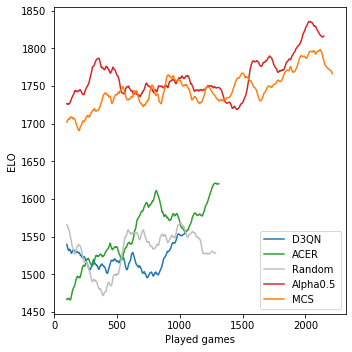

In [49]:
def plot_running_mean(x, y, n=10, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
    cumsum = np.cumsum(np.insert(x, 0, 0))
    running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
    plt.plot(running_mean_x, running_mean_y, **kwargs)

colors = {
    "D3QN": "C0",
    "ACER": "C2",
    "MCS": "C1",
    "Alpha0.5": "C3",
    "Random": "0.75",
}

fig = plt.figure(figsize=(5,5))
    
for name in tournament.agents.keys():
    done = {}
    name_ = name.split("_")[0]
    y = tournament.elos[name]
    x = np.arange(len(y))
    plot_running_mean(
        x,
        y,
        n=200,
        label=None if name_ in done else name_,
        color=colors[name_],
        ls="-",
        lw=1.5
    )
    done[name_] = True

plt.legend(loc="lower right")
        
plt.xlabel("Played games")
plt.ylabel("ELO")

plt.tight_layout()
plt.savefig("elo.pdf")
plt.savefig("elo.png")


## Merle vs. the machine

In [52]:
the_machine = tournament.agents['Alpha0.5']
the_machine.mc_max = 800

session = GameSession(merle, the_machine)

# The DEBUG output shows the moves, which is nice
for name in logging.root.manager.loggerDict:
    if "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.DEBUG)
        

In [53]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   62    _    _    _    _    * 
   81    _    _    _    _    * 
   80:   _    _    _    _    * 
   52    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  15.  23   26   44+  73   78   79   83   93   97 
  Alpha0.5 (player 2):   0 Hornochsen, cards   1   31   33+  64   67   71   82   87   92  101 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  15  23  26  44  73  78  79  83  93  97. Choose one to play! 93


AlphaAlmostZero thoughts:
      1: p = 0.12, n =  84, E[r] =  -6.7
     31: p = 0.09, n =  60, E[r] =  -6.8
     33: p = 0.09, n =  41, E[r] =  -7.7
     64: p = 0.09, n =  70, E[r] =  -6.7
     67: p = 0.09, n =  57, E[r] =  -6.9
     71: p = 0.09, n =  78, E[r] =  -6.4
     82: p = 0.10, n =  77, E[r] =  -6.6
     87: p = 0.10, n =  82, E[r] =  -6.6
     92: p = 0.11, n = 112, E[r] =  -6.2
  x 101: p = 0.13, n = 139, E[r] =  -6.1
Merle    (player 1) plays card 93
Alpha0.5 (player 2) plays card 101
------------------------------------------------------------------------------------------------------------------------
Board:
   62    _    _    _    _    * 
   81   93  101    _    _    * 
   80:   _    _    _    _    * 
   52    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  15.  23   26   44+  73   78   79   83   97 
  Alpha0.5 (player 2):   0 Hornochsen, cards   1   31   33+  64   67   71   82   87   92 
--------------------------------------------------

It is your turn, Merle! You have the following cards:  15  23  26  44  73  78  79  83  97. Choose one to play! 83


AlphaAlmostZero thoughts:
      1: p = 0.10, n = 117, E[r] =  -5.7
     31: p = 0.08, n =  40, E[r] =  -7.0
     33: p = 0.08, n =  56, E[r] =  -6.3
     64: p = 0.10, n =  45, E[r] =  -7.3
     67: p = 0.10, n =  76, E[r] =  -6.5
  x  71: p = 0.11, n = 124, E[r] =  -5.7
     82: p = 0.13, n = 112, E[r] =  -6.1
     87: p = 0.15, n =  87, E[r] =  -6.8
     92: p = 0.16, n = 143, E[r] =  -6.1
Alpha0.5 (player 2) plays card 71
Merle    (player 1) plays card 83
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71    _    _    _    * 
   81   93  101    _    _    * 
   80:  83    _    _    _    * 
   52    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  15.  23   26   44+  73   78   79   97 
  Alpha0.5 (player 2):   0 Hornochsen, cards   1   31   33+  64   67   82   87   92 
------------------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:  15  23  26  44  73  78  79  97. Choose one to play! 78


AlphaAlmostZero thoughts:
      1: p = 0.11, n =  85, E[r] =  -5.7
     31: p = 0.09, n =  75, E[r] =  -5.6
     33: p = 0.09, n =  34, E[r] =  -7.3
     64: p = 0.12, n =  74, E[r] =  -6.0
     67: p = 0.12, n =  92, E[r] =  -5.7
     82: p = 0.15, n = 153, E[r] =  -5.3
  x  87: p = 0.16, n = 173, E[r] =  -5.2
     92: p = 0.17, n = 114, E[r] =  -5.9
Merle    (player 1) plays card 78
Alpha0.5 (player 2) plays card 87
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78    _    _    * 
   81   93  101    _    _    * 
   80:  83   87    _    _    * 
   52    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  15.  23   26   44+  73   79   97 
  Alpha0.5 (player 2):   0 Hornochsen, cards   1   31   33+  64   67   82   92 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  15  23  26  44  73  79  97. Choose one to play! 97


AlphaAlmostZero thoughts:
  x   1: p = 0.12, n = 195, E[r] =  -4.4
     31: p = 0.10, n =  71, E[r] =  -5.2
     33: p = 0.10, n =  71, E[r] =  -5.3
     64: p = 0.13, n =  95, E[r] =  -5.2
     67: p = 0.14, n =  93, E[r] =  -5.3
     82: p = 0.18, n =  89, E[r] =  -5.8
     92: p = 0.22, n = 186, E[r] =  -5.0
Alpha0.5 (player 2) plays card 1
  ...chooses to replace row 4
  ...and gains 1 Hornochsen
Merle    (player 1) plays card 97
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78    _    _    * 
   81   93  101    _    _    * 
   80:  83   87   97    _    * 
    1    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  15.  23   26   44+  73   79 
  Alpha0.5 (player 2):   1 Hornochsen, cards  31   33+  64   67   82   92 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  15  23  26  44  73  79. Choose one to play! 79


AlphaAlmostZero thoughts:
     31: p = 0.12, n = 122, E[r] =  -3.8
     33: p = 0.12, n =  98, E[r] =  -4.0
  x  64: p = 0.15, n = 194, E[r] =  -3.5
     67: p = 0.15, n = 120, E[r] =  -4.0
     82: p = 0.20, n =  98, E[r] =  -4.8
     92: p = 0.26, n = 168, E[r] =  -4.3
Alpha0.5 (player 2) plays card 64
Merle    (player 1) plays card 79
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78   79    _    * 
   81   93  101    _    _    * 
   80:  83   87   97    _    * 
    1   64    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  15.  23   26   44+  73 
  Alpha0.5 (player 2):   1 Hornochsen, cards  31   33+  67   82   92 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  15  23  26  44  73. Choose one to play! 15


AlphaAlmostZero thoughts:
     31: p = 0.07, n =  27, E[r] =  -6.0
     33: p = 0.08, n =  47, E[r] =  -4.6
     67: p = 0.18, n = 110, E[r] =  -4.6
     82: p = 0.28, n = 144, E[r] =  -4.9
  x  92: p = 0.39, n = 472, E[r] =  -3.6
Merle    (player 1) plays card 15
  ...chooses to replace row 4
  ...and gains 2 Hornochsen
Alpha0.5 (player 2) plays card 92
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78   79   92    * 
   81   93  101    _    _    * 
   80:  83   87   97    _    * 
   15.   _    _    _    _    * 
Players:
  Merle    (player 1):   2 Hornochsen, cards  23   26   44+  73 
  Alpha0.5 (player 2):   1 Hornochsen, cards  31   33+  67   82 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  23  26  44  73. Choose one to play! 23


AlphaAlmostZero thoughts:
  x  31: p = 0.24, n =  77, E[r] =  -2.8
     33: p = 0.23, n =  52, E[r] =  -3.5
     67: p = 0.24, n =  59, E[r] =  -3.3
     82: p = 0.28, n =  52, E[r] =  -3.9
Merle    (player 1) plays card 23
Alpha0.5 (player 2) plays card 31
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78   79   92    * 
   81   93  101    _    _    * 
   80:  83   87   97    _    * 
   15.  23   31    _    _    * 
Players:
  Merle    (player 1):   2 Hornochsen, cards  26   44+  73 
  Alpha0.5 (player 2):   1 Hornochsen, cards  33+  67   82 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  26  44  73. Choose one to play! 73


AlphaAlmostZero thoughts:
     33: p = 0.30, n =  12, E[r] =  -5.1
     67: p = 0.30, n =  17, E[r] =  -3.2
  x  82: p = 0.40, n =  31, E[r] =  -2.1
Merle    (player 1) plays card 73
Alpha0.5 (player 2) plays card 82
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78   79   92    * 
   81   93  101    _    _    * 
   80:  83   87   97    _    * 
   15.  23   31   73   82    * 
Players:
  Merle    (player 1):   2 Hornochsen, cards  26   44+
  Alpha0.5 (player 2):   1 Hornochsen, cards  33+  67 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  26  44. Choose one to play! 44


AlphaAlmostZero thoughts:
     33: p = 0.34, n =   6, E[r] =  -2.0
  x  67: p = 0.66, n =  14, E[r] =  -1.5
Merle    (player 1) plays card 44
  ...chooses to replace row 2
  ...and gains 3 Hornochsen
Alpha0.5 (player 2) plays card 67
------------------------------------------------------------------------------------------------------------------------
Board:
   62   71   78   79   92    * 
   44+  67    _    _    _    * 
   80:  83   87   97    _    * 
   15.  23   31   73   82    * 
Players:
  Merle    (player 1):   5 Hornochsen, cards  26 
  Alpha0.5 (player 2):   1 Hornochsen, cards  33+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  26. Choose one to play! 26


Merle    (player 1) plays card 26
  ...chooses to replace row 1
  ...and gains 5 Hornochsen
Alpha0.5 (player 2) plays card 33
------------------------------------------------------------------------------------------------------------------------
Board:
   26   33+   _    _    _    * 
   44+  67    _    _    _    * 
   80:  83   87   97    _    * 
   15.  23   31   73   82    * 
Players:
  Merle    (player 1):  10 Hornochsen, no cards 
  Alpha0.5 (player 2):   1 Hornochsen, no cards 
The game is over! Alpha0.5 (player 2) wins, Merle    (player 1) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------


In [54]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   18    _    _    _    _    * 
   74    _    _    _    _    * 
  100:   _    _    _    _    * 
   35.   _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  20:  21   43   53   60:  64   67   68   80:  96 
  Alpha0.5 (player 2):   0 Hornochsen, cards  24   26   29   36   48   66+  72   77+  85.  99+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  20  21  43  53  60  64  67  68  80  96. Choose one to play! 60


AlphaAlmostZero thoughts:
     24: p = 0.11, n =  83, E[r] =  -8.3
     26: p = 0.11, n =  71, E[r] =  -8.6
     29: p = 0.10, n =  71, E[r] =  -8.6
     36: p = 0.10, n =  62, E[r] =  -8.7
     48: p = 0.09, n =  62, E[r] =  -8.5
     66: p = 0.09, n =  50, E[r] =  -9.0
     72: p = 0.09, n =  56, E[r] =  -8.8
     77: p = 0.09, n = 102, E[r] =  -7.7
  x  85: p = 0.10, n = 147, E[r] =  -7.2
     99: p = 0.12, n =  96, E[r] =  -8.2
Merle    (player 1) plays card 60
Alpha0.5 (player 2) plays card 85
------------------------------------------------------------------------------------------------------------------------
Board:
   18    _    _    _    _    * 
   74   85.   _    _    _    * 
  100:   _    _    _    _    * 
   35.  60:   _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  20:  21   43   53   64   67   68   80:  96 
  Alpha0.5 (player 2):   0 Hornochsen, cards  24   26   29   36   48   66+  72   77+  99+
---------------------------------------------------

It is your turn, Merle! You have the following cards:  20  21  43  53  64  67  68  80  96. Choose one to play! 64


AlphaAlmostZero thoughts:
     24: p = 0.10, n = 111, E[r] =  -7.3
     26: p = 0.10, n =  79, E[r] =  -7.8
     29: p = 0.10, n =  78, E[r] =  -7.9
     36: p = 0.09, n =  33, E[r] = -10.3
  x  48: p = 0.09, n = 121, E[r] =  -7.0
     66: p = 0.10, n =  90, E[r] =  -7.7
     72: p = 0.11, n =  99, E[r] =  -7.7
     77: p = 0.12, n =  52, E[r] =  -9.7
     99: p = 0.18, n = 137, E[r] =  -7.9
Alpha0.5 (player 2) plays card 48
Merle    (player 1) plays card 64
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48    _    _    _    * 
   74   85.   _    _    _    * 
  100:   _    _    _    _    * 
   35.  60:  64    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  20:  21   43   53   67   68   80:  96 
  Alpha0.5 (player 2):   0 Hornochsen, cards  24   26   29   36   66+  72   77+  99+
------------------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:  20  21  43  53  67  68  80  96. Choose one to play! 80


AlphaAlmostZero thoughts:
     24: p = 0.10, n =  42, E[r] = -10.3
     26: p = 0.10, n =  57, E[r] =  -9.3
     29: p = 0.10, n =  73, E[r] =  -8.5
     36: p = 0.10, n =  82, E[r] =  -8.2
     66: p = 0.13, n =  58, E[r] =  -9.9
     72: p = 0.13, n = 125, E[r] =  -8.0
  x  77: p = 0.14, n = 152, E[r] =  -7.9
     99: p = 0.21, n = 211, E[r] =  -7.9
Alpha0.5 (player 2) plays card 77
Merle    (player 1) plays card 80
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48    _    _    _    * 
   74   85.   _    _    _    * 
  100:   _    _    _    _    * 
   35.  60:  64   77+  80:   * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  20:  21   43   53   67   68   96 
  Alpha0.5 (player 2):   0 Hornochsen, cards  24   26   29   36   66+  72   99+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  20  21  43  53  67  68  96. Choose one to play! 53


AlphaAlmostZero thoughts:
     24: p = 0.14, n =  45, E[r] =  -9.9
     26: p = 0.14, n =  64, E[r] =  -8.5
     29: p = 0.14, n =  66, E[r] =  -8.2
     36: p = 0.13, n =  83, E[r] =  -7.6
     66: p = 0.12, n =  23, E[r] = -12.9
     72: p = 0.13, n =  78, E[r] =  -7.8
  x  99: p = 0.20, n = 441, E[r] =  -5.8
Merle    (player 1) plays card 53
Alpha0.5 (player 2) plays card 99
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53    _    _    * 
   74   85.  99+   _    _    * 
  100:   _    _    _    _    * 
   35.  60:  64   77+  80:   * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  20:  21   43   67   68   96 
  Alpha0.5 (player 2):   0 Hornochsen, cards  24   26   29   36   66+  72 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  20  21  43  67  68  96. Choose one to play! 68


AlphaAlmostZero thoughts:
     24: p = 0.15, n = 126, E[r] =  -6.3
     26: p = 0.15, n =  81, E[r] =  -7.2
     29: p = 0.15, n = 113, E[r] =  -6.5
     36: p = 0.16, n =  98, E[r] =  -6.8
     66: p = 0.19, n = 179, E[r] =  -6.1
  x  72: p = 0.20, n = 203, E[r] =  -6.0
Merle    (player 1) plays card 68
Alpha0.5 (player 2) plays card 72
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53   68   72    * 
   74   85.  99+   _    _    * 
  100:   _    _    _    _    * 
   35.  60:  64   77+  80:   * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  20:  21   43   67   96 
  Alpha0.5 (player 2):   0 Hornochsen, cards  24   26   29   36   66+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  20  21  43  67  96. Choose one to play! 96


AlphaAlmostZero thoughts:
     24: p = 0.19, n = 174, E[r] =  -5.9
     26: p = 0.19, n = 176, E[r] =  -5.8
     29: p = 0.19, n = 154, E[r] =  -6.0
  x  36: p = 0.19, n = 178, E[r] =  -5.8
     66: p = 0.24, n = 118, E[r] =  -7.0
Alpha0.5 (player 2) plays card 36
  ...chooses to replace row 3
  ...and gains 3 Hornochsen
Merle    (player 1) plays card 96
  ...and gains 14 Hornochsen
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53   68   72    * 
   74   85.  99+   _    _    * 
   36    _    _    _    _    * 
   96    _    _    _    _    * 
Players:
  Merle    (player 1):  14 Hornochsen, cards  20:  21   43   67 
  Alpha0.5 (player 2):   3 Hornochsen, cards  24   26   29   66+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  20  21  43  67. Choose one to play! 20


AlphaAlmostZero thoughts:
     24: p = 0.27, n =  71, E[r] =  -2.0
  x  26: p = 0.26, n =  85, E[r] =  -1.7
     29: p = 0.25, n =  50, E[r] =  -2.3
     66: p = 0.22, n =  34, E[r] =  -2.8
Merle    (player 1) plays card 20
  ...chooses to replace row 3
  ...and gains 1 Hornochsen
Alpha0.5 (player 2) plays card 26
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53   68   72    * 
   74   85.  99+   _    _    * 
   20:  26    _    _    _    * 
   96    _    _    _    _    * 
Players:
  Merle    (player 1):  15 Hornochsen, cards  21   43   67 
  Alpha0.5 (player 2):   3 Hornochsen, cards  24   29   66+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  21  43  67. Choose one to play! 67


AlphaAlmostZero thoughts:
     24: p = 0.38, n =  24, E[r] =  -1.4
  x  29: p = 0.35, n =  23, E[r] =  -1.3
     66: p = 0.27, n =  13, E[r] =  -2.3
Alpha0.5 (player 2) plays card 29
Merle    (player 1) plays card 67
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53   68   72    * 
   74   85.  99+   _    _    * 
   20:  26   29   67    _    * 
   96    _    _    _    _    * 
Players:
  Merle    (player 1):  15 Hornochsen, cards  21   43 
  Alpha0.5 (player 2):   3 Hornochsen, cards  24   66+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  21  43. Choose one to play! 21


AlphaAlmostZero thoughts:
  x  24: p = 0.56, n =  17, E[r] =  -0.9
     66: p = 0.44, n =   3, E[r] =  -5.0
Merle    (player 1) plays card 21
  ...chooses to replace row 4
  ...and gains 1 Hornochsen
Alpha0.5 (player 2) plays card 24
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53   68   72    * 
   74   85.  99+   _    _    * 
   20:  26   29   67    _    * 
   21   24    _    _    _    * 
Players:
  Merle    (player 1):  16 Hornochsen, cards  43 
  Alpha0.5 (player 2):   3 Hornochsen, cards  66+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  43. Choose one to play! 43


Merle    (player 1) plays card 43
Alpha0.5 (player 2) plays card 66
------------------------------------------------------------------------------------------------------------------------
Board:
   18   48   53   68   72    * 
   74   85.  99+   _    _    * 
   20:  26   29   67    _    * 
   21   24   43   66+   _    * 
Players:
  Merle    (player 1):  16 Hornochsen, no cards 
  Alpha0.5 (player 2):   3 Hornochsen, no cards 
The game is over! Alpha0.5 (player 2) wins, Merle    (player 1) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------


In [55]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   34    _    _    _    _    * 
   19    _    _    _    _    * 
   97    _    _    _    _    * 
   13    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   9   11+  12   39   50:  59   62   65.  91   99+
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   24   25.  27   32   42   66+  67   77+  87 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   9  11  12  39  50  59  62  65  91  99. Choose one to play! 9


AlphaAlmostZero thoughts:
      2: p = 0.11, n =  89, E[r] =  -7.6
     24: p = 0.10, n =  54, E[r] =  -8.5
     25: p = 0.10, n =  77, E[r] =  -7.7
     27: p = 0.10, n =  76, E[r] =  -7.8
     32: p = 0.10, n =  57, E[r] =  -8.3
     42: p = 0.09, n =  79, E[r] =  -7.6
     66: p = 0.10, n =  63, E[r] =  -8.2
     67: p = 0.10, n =  82, E[r] =  -7.7
  x  77: p = 0.11, n = 135, E[r] =  -7.0
     87: p = 0.11, n =  88, E[r] =  -7.6
Merle    (player 1) plays card 9
  ...chooses to replace row 1
  ...and gains 1 Hornochsen
Alpha0.5 (player 2) plays card 77
------------------------------------------------------------------------------------------------------------------------
Board:
    9    _    _    _    _    * 
   19   77+   _    _    _    * 
   97    _    _    _    _    * 
   13    _    _    _    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  11+  12   39   50:  59   62   65.  91   99+
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   24   25.  27   32   42   66+  67 

It is your turn, Merle! You have the following cards:  11  12  39  50  59  62  65  91  99. Choose one to play! 11


AlphaAlmostZero thoughts:
      2: p = 0.11, n =  80, E[r] =  -7.2
  x  24: p = 0.10, n = 121, E[r] =  -6.6
     25: p = 0.10, n =  91, E[r] =  -6.9
     27: p = 0.10, n =  82, E[r] =  -7.1
     32: p = 0.10, n =  53, E[r] =  -7.9
     42: p = 0.10, n =  82, E[r] =  -6.9
     66: p = 0.11, n = 123, E[r] =  -6.7
     67: p = 0.11, n =  75, E[r] =  -7.4
     87: p = 0.14, n =  93, E[r] =  -7.3
Merle    (player 1) plays card 11
Alpha0.5 (player 2) plays card 24
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+   _    _    _    * 
   19   77+   _    _    _    * 
   97    _    _    _    _    * 
   13   24    _    _    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  12   39   50:  59   62   65.  91   99+
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   25.  27   32   42   66+  67   87 
------------------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:  12  39  50  59  62  65  91  99. Choose one to play! 12


AlphaAlmostZero thoughts:
      2: p = 0.12, n =  86, E[r] =  -8.3
     25: p = 0.11, n =  36, E[r] = -10.5
     27: p = 0.11, n =  61, E[r] =  -8.7
     32: p = 0.11, n =  42, E[r] =  -9.9
     42: p = 0.11, n =  92, E[r] =  -7.9
     66: p = 0.14, n = 150, E[r] =  -7.5
     67: p = 0.14, n =  80, E[r] =  -8.8
  x  87: p = 0.18, n = 253, E[r] =  -7.2
Merle    (player 1) plays card 12
Alpha0.5 (player 2) plays card 87
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12    _    _    * 
   19   77+  87    _    _    * 
   97    _    _    _    _    * 
   13   24    _    _    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  39   50:  59   62   65.  91   99+
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   25.  27   32   42   66+  67 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  39  50  59  62  65  91  99. Choose one to play! 99


AlphaAlmostZero thoughts:
      2: p = 0.16, n =  98, E[r] =  -8.6
     25: p = 0.13, n =  66, E[r] =  -9.0
     27: p = 0.13, n =  76, E[r] =  -8.7
     32: p = 0.13, n =  77, E[r] =  -8.7
     42: p = 0.13, n =  73, E[r] =  -8.8
  x  66: p = 0.16, n = 277, E[r] =  -6.9
     67: p = 0.16, n = 133, E[r] =  -7.9
Alpha0.5 (player 2) plays card 66
Merle    (player 1) plays card 99
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12    _    _    * 
   19   77+  87    _    _    * 
   97   99+   _    _    _    * 
   13   24   66+   _    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  39   50:  59   62   65.  91 
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   25.  27   32   42   67 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  39  50  59  62  65  91. Choose one to play! 62


AlphaAlmostZero thoughts:
      2: p = 0.17, n =  77, E[r] = -11.1
  x  25: p = 0.15, n = 186, E[r] =  -9.1
     27: p = 0.15, n = 101, E[r] = -10.0
     32: p = 0.15, n = 143, E[r] =  -9.4
     42: p = 0.16, n =  99, E[r] = -10.3
     67: p = 0.22, n = 194, E[r] =  -9.5
Alpha0.5 (player 2) plays card 25
Merle    (player 1) plays card 62
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12   25.  62    * 
   19   77+  87    _    _    * 
   97   99+   _    _    _    * 
   13   24   66+   _    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  39   50:  59   65.  91 
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   27   32   42   67 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  39  50  59  65  91. Choose one to play! 91


AlphaAlmostZero thoughts:
      2: p = 0.19, n =  48, E[r] = -12.3
     27: p = 0.18, n =  38, E[r] = -13.3
     32: p = 0.18, n =  31, E[r] = -14.8
     42: p = 0.19, n =  46, E[r] = -12.5
  x  67: p = 0.26, n = 637, E[r] =  -7.1
Alpha0.5 (player 2) plays card 67
Merle    (player 1) plays card 91
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12   25.  62    * 
   19   77+  87   91    _    * 
   97   99+   _    _    _    * 
   13   24   66+  67    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  39   50:  59   65.
  Alpha0.5 (player 2):   0 Hornochsen, cards   2   27   32   42 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  39  50  59  65. Choose one to play! 50


AlphaAlmostZero thoughts:
      2: p = 0.25, n =  57, E[r] =  -9.3
     27: p = 0.23, n =  49, E[r] =  -9.4
     32: p = 0.24, n =  56, E[r] =  -9.2
  x  42: p = 0.27, n =  78, E[r] =  -8.8
Alpha0.5 (player 2) plays card 42
  ...chooses to replace row 3
  ...and gains 6 Hornochsen
Merle    (player 1) plays card 50
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12   25.  62    * 
   19   77+  87   91    _    * 
   42   50:   _    _    _    * 
   13   24   66+  67    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  39   59   65.
  Alpha0.5 (player 2):   6 Hornochsen, cards   2   27   32 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  39  59  65. Choose one to play! 59


AlphaAlmostZero thoughts:
  x   2: p = 0.39, n =  25, E[r] =  -6.1
     27: p = 0.31, n =  17, E[r] =  -6.8
     32: p = 0.30, n =  18, E[r] =  -6.4
Alpha0.5 (player 2) plays card 2
  ...chooses to replace row 3
  ...and gains 4 Hornochsen
Merle    (player 1) plays card 59
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12   25.  62    * 
   19   77+  87   91    _    * 
    2   59    _    _    _    * 
   13   24   66+  67    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  39   65.
  Alpha0.5 (player 2):  10 Hornochsen, cards  27   32 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  39  65. Choose one to play! 39


AlphaAlmostZero thoughts:
  x  27: p = 0.50, n =  11, E[r] =  -2.4
     32: p = 0.50, n =   9, E[r] =  -2.4
Alpha0.5 (player 2) plays card 27
  ...chooses to replace row 3
  ...and gains 2 Hornochsen
Merle    (player 1) plays card 39
------------------------------------------------------------------------------------------------------------------------
Board:
    9   11+  12   25.  62    * 
   19   77+  87   91    _    * 
   27   39    _    _    _    * 
   13   24   66+  67    _    * 
Players:
  Merle    (player 1):   1 Hornochsen, cards  65.
  Alpha0.5 (player 2):  12 Hornochsen, cards  32 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  65. Choose one to play! 65


Alpha0.5 (player 2) plays card 32
  ...chooses to replace row 3
  ...and gains 2 Hornochsen
Merle    (player 1) plays card 65
  ...and gains 10 Hornochsen
------------------------------------------------------------------------------------------------------------------------
Board:
   65.   _    _    _    _    * 
   19   77+  87   91    _    * 
   32    _    _    _    _    * 
   13   24   66+  67    _    * 
Players:
  Merle    (player 1):  11 Hornochsen, no cards 
  Alpha0.5 (player 2):  14 Hornochsen, no cards 
The game is over! Merle    (player 1) wins, Alpha0.5 (player 2) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------


In [56]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   31    _    _    _    _    * 
   26    _    _    _    _    * 
   88+   _    _    _    _    * 
   34    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   21   41   52   57   63   64   98  102 
  Alpha0.5 (player 2):   0 Hornochsen, cards  11+  15.  16   27   60:  79   83   86   91   96 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   4   8  21  41  52  57  63  64  98 102. Choose one to play! 63


AlphaAlmostZero thoughts:
     11: p = 0.11, n =  39, E[r] = -11.6
     15: p = 0.10, n =  80, E[r] =  -9.4
     16: p = 0.10, n =  73, E[r] =  -9.6
     27: p = 0.09, n =  72, E[r] =  -9.3
     60: p = 0.09, n =  45, E[r] = -10.4
     79: p = 0.10, n =  89, E[r] =  -9.1
     83: p = 0.10, n =  81, E[r] =  -9.3
  x  86: p = 0.10, n = 132, E[r] =  -8.6
     91: p = 0.11, n = 113, E[r] =  -8.9
     96: p = 0.11, n =  76, E[r] =  -9.7
Merle    (player 1) plays card 63
Alpha0.5 (player 2) plays card 86
------------------------------------------------------------------------------------------------------------------------
Board:
   31    _    _    _    _    * 
   26    _    _    _    _    * 
   88+   _    _    _    _    * 
   34   63   86    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   21   41   52   57   64   98  102 
  Alpha0.5 (player 2):   0 Hornochsen, cards  11+  15.  16   27   60:  79   83   91   96 
---------------------------------------------------

It is your turn, Merle! You have the following cards:   4   8  21  41  52  57  64  98 102. Choose one to play! 57


AlphaAlmostZero thoughts:
     11: p = 0.14, n =  86, E[r] =  -9.0
     15: p = 0.13, n =  98, E[r] =  -8.5
     16: p = 0.13, n = 119, E[r] =  -8.1
     27: p = 0.11, n =  80, E[r] =  -8.7
     60: p = 0.09, n =  58, E[r] =  -8.8
     79: p = 0.09, n =  94, E[r] =  -8.0
  x  83: p = 0.10, n = 104, E[r] =  -7.8
     91: p = 0.10, n =  90, E[r] =  -8.2
     96: p = 0.11, n =  71, E[r] =  -8.9
Merle    (player 1) plays card 57
Alpha0.5 (player 2) plays card 83
------------------------------------------------------------------------------------------------------------------------
Board:
   31   57   83    _    _    * 
   26    _    _    _    _    * 
   88+   _    _    _    _    * 
   34   63   86    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   21   41   52   64   98  102 
  Alpha0.5 (player 2):   0 Hornochsen, cards  11+  15.  16   27   60:  79   91   96 
------------------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:   4   8  21  41  52  64  98 102. Choose one to play! 98


AlphaAlmostZero thoughts:
     11: p = 0.12, n =  93, E[r] =  -8.1
  x  15: p = 0.11, n = 110, E[r] =  -7.6
     16: p = 0.11, n = 105, E[r] =  -7.7
     27: p = 0.10, n =  67, E[r] =  -8.5
     60: p = 0.11, n =  97, E[r] =  -7.9
     79: p = 0.13, n =  82, E[r] =  -8.6
     91: p = 0.15, n = 132, E[r] =  -7.7
     96: p = 0.16, n = 114, E[r] =  -8.2
Alpha0.5 (player 2) plays card 15
  ...chooses to replace row 2
  ...and gains 1 Hornochsen
Merle    (player 1) plays card 98
------------------------------------------------------------------------------------------------------------------------
Board:
   31   57   83    _    _    * 
   15.   _    _    _    _    * 
   88+  98    _    _    _    * 
   34   63   86    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   21   41   52   64  102 
  Alpha0.5 (player 2):   1 Hornochsen, cards  11+  16   27   60:  79   91   96 
-----------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:   4   8  21  41  52  64 102. Choose one to play! 21


AlphaAlmostZero thoughts:
     11: p = 0.10, n =  62, E[r] =  -7.5
  x  16: p = 0.10, n = 108, E[r] =  -6.6
     27: p = 0.10, n =  60, E[r] =  -7.6
     60: p = 0.13, n = 122, E[r] =  -6.9
     79: p = 0.17, n = 132, E[r] =  -7.1
     91: p = 0.20, n = 151, E[r] =  -7.2
     96: p = 0.21, n = 165, E[r] =  -7.2
Alpha0.5 (player 2) plays card 16
Merle    (player 1) plays card 21
------------------------------------------------------------------------------------------------------------------------
Board:
   31   57   83    _    _    * 
   15.  16   21    _    _    * 
   88+  98    _    _    _    * 
   34   63   86    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   41   52   64  102 
  Alpha0.5 (player 2):   1 Hornochsen, cards  11+  27   60:  79   91   96 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   4   8  41  52  64 102. Choose one to play! 64


AlphaAlmostZero thoughts:
     11: p = 0.10, n =  42, E[r] =  -9.5
  x  27: p = 0.10, n = 135, E[r] =  -6.8
     60: p = 0.13, n =  61, E[r] =  -8.9
     79: p = 0.17, n = 147, E[r] =  -7.5
     91: p = 0.23, n = 139, E[r] =  -8.3
     96: p = 0.27, n = 276, E[r] =  -7.2
Alpha0.5 (player 2) plays card 27
Merle    (player 1) plays card 64
------------------------------------------------------------------------------------------------------------------------
Board:
   31   57   83    _    _    * 
   15.  16   21   27   64    * 
   88+  98    _    _    _    * 
   34   63   86    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   41   52  102 
  Alpha0.5 (player 2):   1 Hornochsen, cards  11+  60:  79   91   96 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   4   8  41  52 102. Choose one to play! 102


AlphaAlmostZero thoughts:
     11: p = 0.09, n =  50, E[r] =  -6.7
     60: p = 0.13, n =  89, E[r] =  -6.1
     79: p = 0.20, n =  86, E[r] =  -7.3
     91: p = 0.27, n = 209, E[r] =  -5.8
  x  96: p = 0.30, n = 366, E[r] =  -5.2
Alpha0.5 (player 2) plays card 96
Merle    (player 1) plays card 102
------------------------------------------------------------------------------------------------------------------------
Board:
   31   57   83    _    _    * 
   15.  16   21   27   64    * 
   88+  98  102    _    _    * 
   34   63   86   96    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards   4    8   41   52 
  Alpha0.5 (player 2):   1 Hornochsen, cards  11+  60:  79   91 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   4   8  41  52. Choose one to play! 4


AlphaAlmostZero thoughts:
     11: p = 0.07, n =  11, E[r] =  -7.3
     60: p = 0.17, n =  44, E[r] =  -5.7
     79: p = 0.30, n =  59, E[r] =  -6.4
  x  91: p = 0.45, n = 126, E[r] =  -5.6
Merle    (player 1) plays card 4
  ...chooses to replace row 1
  ...and gains 3 Hornochsen
Alpha0.5 (player 2) plays card 91
  ...and gains 6 Hornochsen
------------------------------------------------------------------------------------------------------------------------
Board:
    4    _    _    _    _    * 
   91    _    _    _    _    * 
   88+  98  102    _    _    * 
   34   63   86   96    _    * 
Players:
  Merle    (player 1):   3 Hornochsen, cards   8   41   52 
  Alpha0.5 (player 2):   7 Hornochsen, cards  11+  60:  79 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   8  41  52. Choose one to play! 8


AlphaAlmostZero thoughts:
     11: p = 0.51, n =  25, E[r] =  -2.9
  x  60: p = 0.25, n =  20, E[r] =  -1.0
     79: p = 0.24, n =  15, E[r] =  -1.9
Merle    (player 1) plays card 8
Alpha0.5 (player 2) plays card 60
------------------------------------------------------------------------------------------------------------------------
Board:
    4    8   60:   _    _    * 
   91    _    _    _    _    * 
   88+  98  102    _    _    * 
   34   63   86   96    _    * 
Players:
  Merle    (player 1):   3 Hornochsen, cards  41   52 
  Alpha0.5 (player 2):   7 Hornochsen, cards  11+  79 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  41  52. Choose one to play! 41


AlphaAlmostZero thoughts:
  x  11: p = 0.54, n =  12, E[r] =  -0.9
     79: p = 0.46, n =   8, E[r] =  -1.1
Alpha0.5 (player 2) plays card 11
  ...chooses to replace row 2
  ...and gains 1 Hornochsen
Merle    (player 1) plays card 41
------------------------------------------------------------------------------------------------------------------------
Board:
    4    8   60:   _    _    * 
   11+  41    _    _    _    * 
   88+  98  102    _    _    * 
   34   63   86   96    _    * 
Players:
  Merle    (player 1):   3 Hornochsen, cards  52 
  Alpha0.5 (player 2):   8 Hornochsen, cards  79 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  52. Choose one to play! 52


Merle    (player 1) plays card 52
Alpha0.5 (player 2) plays card 79
------------------------------------------------------------------------------------------------------------------------
Board:
    4    8   60:  79    _    * 
   11+  41   52    _    _    * 
   88+  98  102    _    _    * 
   34   63   86   96    _    * 
Players:
  Merle    (player 1):   3 Hornochsen, no cards 
  Alpha0.5 (player 2):   8 Hornochsen, no cards 
The game is over! Merle    (player 1) wins, Alpha0.5 (player 2) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------


In [57]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   78    _    _    _    _    * 
   33+   _    _    _    _    * 
    8    _    _    _    _    * 
   23    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  25.  31   57   58   60:  63   66+  83   93  101 
  Alpha0.5 (player 2):   0 Hornochsen, cards  19   32   48   56   59   68   90:  98  102  104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  31  57  58  60  63  66  83  93 101. Choose one to play! 57


AlphaAlmostZero thoughts:
     19: p = 0.08, n =  46, E[r] =  -7.9
     32: p = 0.07, n =  51, E[r] =  -7.3
     48: p = 0.07, n =  31, E[r] =  -8.7
     56: p = 0.08, n =  31, E[r] =  -9.0
     59: p = 0.08, n =  28, E[r] =  -9.6
     68: p = 0.09, n =  41, E[r] =  -8.5
     90: p = 0.12, n =  83, E[r] =  -7.4
  x  98: p = 0.13, n = 207, E[r] =  -6.1
    102: p = 0.14, n = 140, E[r] =  -6.7
    104: p = 0.14, n = 142, E[r] =  -6.8
Merle    (player 1) plays card 57
Alpha0.5 (player 2) plays card 98
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98    _    _    _    * 
   33+  57    _    _    _    * 
    8    _    _    _    _    * 
   23    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  25.  31   58   60:  63   66+  83   93  101 
  Alpha0.5 (player 2):   0 Hornochsen, cards  19   32   48   56   59   68   90: 102  104 
---------------------------------------------------

It is your turn, Merle! You have the following cards:  25  31  58  60  63  66  83  93 101. Choose one to play! 101


AlphaAlmostZero thoughts:
     19: p = 0.08, n =  74, E[r] =  -6.4
     32: p = 0.08, n =  72, E[r] =  -6.3
     48: p = 0.09, n =  64, E[r] =  -6.9
     56: p = 0.10, n =  54, E[r] =  -7.3
     59: p = 0.10, n =  37, E[r] =  -8.8
     68: p = 0.11, n =  34, E[r] =  -9.4
  x  90: p = 0.13, n = 201, E[r] =  -5.7
    102: p = 0.15, n = 118, E[r] =  -6.6
    104: p = 0.15, n = 146, E[r] =  -6.3
Alpha0.5 (player 2) plays card 90
Merle    (player 1) plays card 101
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98  101    _    _    * 
   33+  57   90:   _    _    * 
    8    _    _    _    _    * 
   23    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  25.  31   58   60:  63   66+  83   93 
  Alpha0.5 (player 2):   0 Hornochsen, cards  19   32   48   56   59   68  102  104 
-----------------------------------------------------------------------------------------------------

It is your turn, Merle! You have the following cards:  25  31  58  60  63  66  83  93. Choose one to play! 93


AlphaAlmostZero thoughts:
  x  19: p = 0.10, n = 134, E[r] =  -4.1
     32: p = 0.10, n =  99, E[r] =  -4.4
     48: p = 0.10, n =  61, E[r] =  -5.2
     56: p = 0.11, n =  83, E[r] =  -4.9
     59: p = 0.11, n =  77, E[r] =  -5.0
     68: p = 0.12, n =  69, E[r] =  -5.3
    102: p = 0.18, n = 143, E[r] =  -4.7
    104: p = 0.18, n = 134, E[r] =  -4.8
Alpha0.5 (player 2) plays card 19
Merle    (player 1) plays card 93
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98  101    _    _    * 
   33+  57   90:  93    _    * 
    8   19    _    _    _    * 
   23    _    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  25.  31   58   60:  63   66+  83 
  Alpha0.5 (player 2):   0 Hornochsen, cards  32   48   56   59   68  102  104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  31  58  60  63  66  83. Choose one to play! 58


AlphaAlmostZero thoughts:
     32: p = 0.12, n =  56, E[r] =  -6.0
     48: p = 0.12, n =  33, E[r] =  -8.1
     56: p = 0.13, n =  49, E[r] =  -6.6
     59: p = 0.13, n =  64, E[r] =  -5.9
     68: p = 0.14, n =  69, E[r] =  -5.7
  x 102: p = 0.18, n = 446, E[r] =  -3.4
    104: p = 0.19, n =  83, E[r] =  -6.1
Merle    (player 1) plays card 58
Alpha0.5 (player 2) plays card 102
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98  101  102    _    * 
   33+  57   90:  93    _    * 
    8   19    _    _    _    * 
   23   58    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  25.  31   60:  63   66+  83 
  Alpha0.5 (player 2):   0 Hornochsen, cards  32   48   56   59   68  104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  31  60  63  66  83. Choose one to play! 25


AlphaAlmostZero thoughts:
  x  32: p = 0.15, n = 152, E[r] =  -3.1
     48: p = 0.15, n = 112, E[r] =  -3.6
     56: p = 0.14, n =  96, E[r] =  -3.7
     59: p = 0.14, n = 124, E[r] =  -3.4
     68: p = 0.15, n = 117, E[r] =  -3.5
    104: p = 0.27, n = 199, E[r] =  -3.5
Merle    (player 1) plays card 25
Alpha0.5 (player 2) plays card 32
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98  101  102    _    * 
   33+  57   90:  93    _    * 
    8   19   25.  32    _    * 
   23   58    _    _    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  31   60:  63   66+  83 
  Alpha0.5 (player 2):   0 Hornochsen, cards  48   56   59   68  104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  31  60  63  66  83. Choose one to play! 66


AlphaAlmostZero thoughts:
     48: p = 0.12, n =  87, E[r] =  -4.9
     56: p = 0.14, n =  55, E[r] =  -6.1
     59: p = 0.14, n =  59, E[r] =  -6.1
  x  68: p = 0.17, n = 305, E[r] =  -3.9
    104: p = 0.43, n = 294, E[r] =  -4.9
Merle    (player 1) plays card 66
Alpha0.5 (player 2) plays card 68
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98  101  102    _    * 
   33+  57   90:  93    _    * 
    8   19   25.  32    _    * 
   23   58   66+  68    _    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  31   60:  63   83 
  Alpha0.5 (player 2):   0 Hornochsen, cards  48   56   59  104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  31  60  63  83. Choose one to play! 83


AlphaAlmostZero thoughts:
  x  48: p = 0.09, n =  25, E[r] =  -4.4
     56: p = 0.12, n =  11, E[r] =  -9.0
     59: p = 0.14, n =  30, E[r] =  -4.9
    104: p = 0.65, n = 174, E[r] =  -4.5
Alpha0.5 (player 2) plays card 48
Merle    (player 1) plays card 83
------------------------------------------------------------------------------------------------------------------------
Board:
   78   98  101  102    _    * 
   33+  57   90:  93    _    * 
    8   19   25.  32   48    * 
   23   58   66+  68   83    * 
Players:
  Merle    (player 1):   0 Hornochsen, cards  31   60:  63 
  Alpha0.5 (player 2):   0 Hornochsen, cards  56   59  104 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  31  60  63. Choose one to play! 31


AlphaAlmostZero thoughts:
     56: p = 0.14, n =   4, E[r] =  -6.2
     59: p = 0.15, n =   4, E[r] =  -6.2
  x 104: p = 0.71, n =  52, E[r] =  -4.2
Merle    (player 1) plays card 31
  ...chooses to replace row 1
  ...and gains 4 Hornochsen
Alpha0.5 (player 2) plays card 104
------------------------------------------------------------------------------------------------------------------------
Board:
   31    _    _    _    _    * 
   33+  57   90:  93  104    * 
    8   19   25.  32   48    * 
   23   58   66+  68   83    * 
Players:
  Merle    (player 1):   4 Hornochsen, cards  60:  63 
  Alpha0.5 (player 2):   0 Hornochsen, cards  56   59 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  60  63. Choose one to play! 60


../rl_6_nimmt/agents/mcts.py:302: RuntimeWarning: invalid value encountered in true_divide
  q = np.clip((q - min_return) / (max_return - min_return), 0., 1.)
AlphaAlmostZero thoughts:
  x  56: p = 0.50, n =  11, E[r] =  -5.5
     59: p = 0.50, n =   9, E[r] =  -6.0
Alpha0.5 (player 2) plays card 56
  ...and gains 6 Hornochsen
Merle    (player 1) plays card 60
------------------------------------------------------------------------------------------------------------------------
Board:
   31    _    _    _    _    * 
   33+  57   90:  93  104    * 
   56   60:   _    _    _    * 
   23   58   66+  68   83    * 
Players:
  Merle    (player 1):   4 Hornochsen, cards  63 
  Alpha0.5 (player 2):   6 Hornochsen, cards  59 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  63. Choose one to play! 63


Alpha0.5 (player 2) plays card 59
Merle    (player 1) plays card 63
------------------------------------------------------------------------------------------------------------------------
Board:
   31   59    _    _    _    * 
   33+  57   90:  93  104    * 
   56   60:  63    _    _    * 
   23   58   66+  68   83    * 
Players:
  Merle    (player 1):   4 Hornochsen, no cards 
  Alpha0.5 (player 2):   6 Hornochsen, no cards 
The game is over! Merle    (player 1) wins, Alpha0.5 (player 2) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------
